# Recurrent Neural Network (RNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(0)

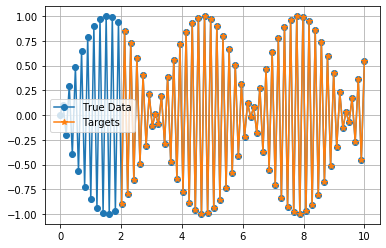

In [2]:
#Data
window = 20
n_data = 100 #Amount of Data
domain_x = 10 #Domain of Data
t = np.asarray(np.linspace(0, domain_x, n_data)) #Create X data
xt = np.asarray([abs(np.sin(t[i])) if i%2 else -abs(np.sin(t[i])) for i in range(n_data)]) #Create target data
x_w = np.asarray([xt[i:i+window] for i in range(len(xt)-window)]) #Embeding of window size
y = np.asarray(xt[window:]) #Targets
plt.plot(t,xt,label='True Data', marker='o') #
plt.plot(t[window:],y,marker='*',label='Targets')
plt.legend(['True Data','Targets'])
plt.grid()
plt.show()

In [3]:
def MSE(y_true,y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def d_sig(x):
    return sigmoid(x)*(1-sigmoid(x))

In [6]:
#LSTM cell
class LSTM:
    
    def __init__(self, input_size, h_size):
        self.input_size = input_size
        self.h_size = h_size
        self.Wf = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Forget weights
        self.Wi = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Input weights
        self.Wo = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Output weights
        self.Wc = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Cell Input weights
        self.bf = np.random.randn(h_size) #Forget bias
        self.bi = np.random.randn(h_size) #Input bias
        self.bo = np.random.randn(h_size) #Output bias
        self.bc = np.random.randn(h_size) #Cell Input bias
        self.c_state = np.random.uniform(-1, 1, (h_size,1)) #Cell state
        self.h_state = np.random.uniform(-1, 1, (h_size,1)) #Hidden state
        
        self.concat = np.zeros((input_size + h_size)) #Concatenated Values
        
        self.f = 0 #forget gate
        self.i = 0 #input gate
        self.o = 0 #output gate
        self.c_hat = 0 #candidate cell state
        
        self.Wf_g = np.zeros((h_size, input_size + h_size)) #Forget gradient
        self.Wi_g = np.zeros((h_size, input_size + h_size)) #Input Gradient
        self.Wo_g = np.zeros((h_size, input_size + h_size)) #Output Gradient
        self.Wc_g = np.zeros((h_size, input_size + h_size)) #Cell Gradient
        self.bf_g = np.zeros(h_size) #Forget bias gradient
        self.bi_g = np.zeros(h_size) #Input bias gradient
        self.bo_g = np.zeros(h_size) #Output bias gradient
        self.bc_g = np.zeros(h_size) #Cell bias Gradient
        self.c_state_g = np.zeros(h_size) #Cell State Gradient
        self.h_state_g = np.zeros(h_size) #Hidden State Gradient
        
    def forward(self, x, h_prev, c_prev):
        self.concat = np.hstack((h_prev, x)) #Concatenated hidden state and input
        self.f = sigmoid(np.dot(self.Wf, self.concat) + self.bf) #Forget cell
        self.i = sigmoid(np.dot(self.Wi, self.concat) + self.bi) #Input cell
        self.o = sigmoid(np.dot(self.Wo, self.concat) + self.bo) #Output cell
        self.c_hat = np.tanh(np.dot(self.Wc, self.concat) + self.bc) #Cell state

        self.c_state = self.f * c_prev + self.i * self.c_hat #New Cell State
        self.h_state = self.o * np.tanh(self.c_state) #New Hidden State

        return self.h_state, self.c_state
    
    def backward(self, x, d_h_state, d_c_state):
        self.h_state_g = d_h_state 
        d_o = d_h_state * np.tanh(self.c_state) * d_sig(np.dot(self.Wo, self.concat) + self.bo)
        d_c = (d_h_state * self.o * (1 - np.tanh(self.c_state)**2)) + d_c_state
        d_i = d_c * self.c_hat * d_sig(np.dot(self.Wi, self.concat) + self.bi)
        d_f = d_c * self.c_state * d_sig(np.dot(self.Wf, self.concat) + self.bf)
        d_c_hat = d_c * self.i * (1 - self.c_hat**2)
        
        self.Wf_g += np.outer(d_f, self.concat)
        self.Wi_g += np.outer(d_i, self.concat)
        self.Wc_g += np.outer(d_c_hat, self.concat)
        self.Wo_g += np.outer(d_o, self.concat)
        
        self.bf_g += d_f
        self.bi_g += d_i
        self.bc_g += d_c_hat
        self.bo_g += d_o
        
        dconcat = np.dot(self.Wf.T, d_f) + np.dot(self.Wi.T, d_i) + np.dot(self.Wc.T, d_c_hat) + np.dot(self.Wo.T, d_o)
        
        dx = dconcat[:self.input_size] 
        dh_prev = dconcat[self.input_size:]

        return dx, dh_prev, d_c * self.f
    
    def update(self, lr=0.0001):
        self.Wf -= lr * self.Wf_g
        self.Wi -= lr * self.Wi_g
        self.Wc -= lr * self.Wc_g
        self.Wo -= lr * self.Wo_g
        
        self.bf -= lr * self.bf_g
        self.bi -= lr * self.bi_g
        self.bc -= lr * self.bc_g
        self.bo -= lr * self.bo_g
        
        # Reset gradients after updating
        self.Wf_g.fill(0)
        self.Wi_g.fill(0)
        self.Wc_g.fill(0)
        self.Wo_g.fill(0)
        
        self.bf_g.fill(0)
        self.bi_g.fill(0)
        self.bc_g.fill(0)
        self.bo_g.fill(0)


In [7]:
#Forward Pass
L_Cell = LSTM(window,5)
H,C = L_Cell.forward(x_w[0],[0,0,0,0,0],[0])
print(H,C)

[ 0.2365884  -0.11413254  0.04015705 -0.07204903  0.31070326] [ 0.60816209 -0.48200461  0.05854015 -0.1115542   0.38534406]


In [8]:
dX, dH, dC = L_Cell.backward(x_w[0],H,C)
print(dX,dH,dC)

[0.26726315 0.43491757 0.16082922 0.12255476 0.18149605 0.17341257
 0.29783011 0.39340488 0.24064696 0.42135466 0.21423836 0.18054201
 0.25795567 0.24571369 0.35044446 0.24636937 0.31522196 0.16422213
 0.17349239 0.35462109] [0.24334448 0.04423859 0.32035122 0.27327226 0.10925698] [ 0.52480141 -0.24681609  0.03836944 -0.1354745   0.46710636]


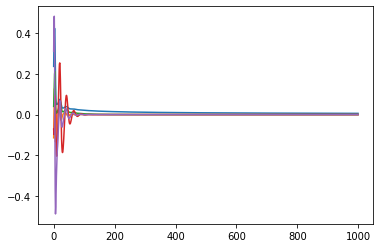

In [9]:
Hs = []
H = [0,0,0,0,0]
C = [0,0,0,0,0]
for i in range(1000):
    H,C = L_Cell.forward(x_w[0],H,C)
    dX, dH, dC = L_Cell.backward(x_w[0],H,C)
    L_Cell.update(0.1)
    Hs.append(H)
Hs = np.asarray(Hs)
plt.plot(Hs)

In [10]:
class RNN:
    def __init__(self, input_size, h_size, out_size, lr=0.001, x_dim=1):
        self.input_size = input_size
        self.h_size = h_size
        self.out_size = out_size

        self.LSTM_Cells = []
        for j in range(self.input_size):
            self.LSTM_Cells.append(LSTM(x_dim, self.h_size))

        self.H = [np.zeros(h_size)]
        self.C = [np.zeros(h_size)]

        self.Wy = np.random.rand(out_size, h_size)
        self.by = np.zeros(out_size)

        self.dWy = np.zeros((out_size, h_size))
        self.dby = np.zeros(out_size)

        self.lr = lr

        self.Losses = []

    def forward(self, x):
        self.H = [np.zeros(self.h_size)]
        self.C = [np.zeros(self.h_size)]
        for t in range(self.input_size):
            h, c = self.LSTM_Cells[t].forward(x[t], self.H[-1], self.C[-1])
            self.H.append(h)
            self.C.append(c)
        y = self.Wy.dot(h) + self.by
        return y

    def backward(self, x, dy):
        self.dWy = dy * self.H[-1].reshape(-1, 1).T
        self.dby = dy

        dh = self.Wy.T.dot(dy)
        dc = np.zeros_like(self.C[-1])
        for t in reversed(range(self.input_size)):
            dx, dh, dc = self.LSTM_Cells[t].backward(x[t], dh, dc)
            
    def shuffle_data(self,x,y):
        np.random.seed(789)
        np.

    def train(self, x, yt, epochs=1000, lr_dec=False, shuffle=True):
        
        
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(len(x)):
                out = self.forward(x[i])
                loss = MSE(out, yt[i])
                epoch_loss += loss

                dy = out - yt[i]
                self.backward(x[i], dy)

                self.Wy -= self.lr * self.dWy
                self.by -= self.lr * self.dby

                for l in self.LSTM_Cells:
                    l.update(self.lr)
            if lr_dec == True:        
                self.lr *= 0.99999

            self.Losses.append(epoch_loss / len(x))
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(x)}',end='\r')

In [11]:
R = RNN(1,20,1,x_dim=window)
R.forward(x_w)

array([0.75765309])

In [12]:
R = RNN(window,5,1)
R.train(x_w,y,3000)

In [13]:
R.train(x_w,y,1000,lr_dec=True)

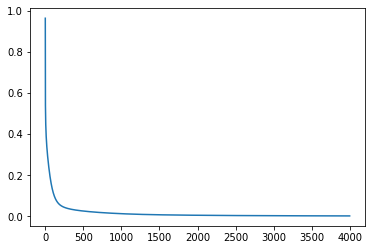

In [14]:
plt.plot(R.Losses)

In [15]:
def Predict(R,N,xt,plot=True):
    #Prediction
    N = N - 3
    window = R.input_size
    y_pred = np.zeros((N + window))  # +window to include the first window predictions

    # Generate the first window predictions
    y_pred[0] = R.forward(xt[-window:])
    for i in range(1,window):
        y_pred[i] = R.forward(np.concatenate((xt[-window + i:], y_pred[:i])))

    # Generate the remaining N predictions
    for i in range(window, N + window):
        y_pred[i] = R.forward(y_pred[i - window:i])

    # Concatenate initial data with predictions
    Y = np.concatenate((xt, y_pred))
    T = list(range(Y.shape[0]))
    
    if plot == True:
        plt.plot(T[:n_data],Y[:n_data],marker='o',label='Training')
        plt.plot(T[n_data:],Y[n_data:],marker='*',label='Predicted')
        plt.legend(['Training','Predicted'])
        plt.grid()
        plt.show()
    
    return y_pred

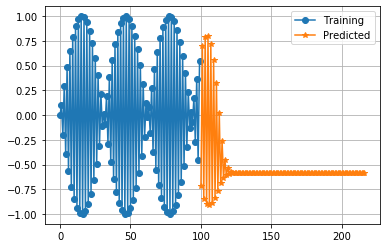

In [16]:
y_pred = Predict(R,100,xt,True)

In [17]:
def Op_Init_Net(NN,x_w,h_size,y):
    in_size = 1 if len(y.shape) == 1 else y.shape[1]
    Nets = [RNN(x_w.shape[1],h_size,in_size) for i in range(NN)]
    L = np.zeros((NN))
    for n in range(len(Nets)):
        l = 0
        for j in range(len(x_w)):
            l += MSE(Nets[n].forward(x_w[j]),y[j])
        L[n] = l
    return Nets[np.argmin(L)]

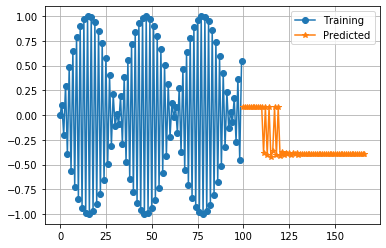

In [18]:
R1 = RNN(window,50,1)
R1.train(x_w,y,1000)
y_pred = Predict(R1,50,xt,True)

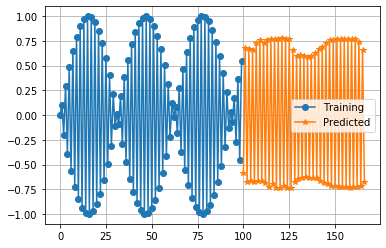

In [19]:
R2 = Op_Init_Net(100,x_w,50,y)
R2.train(x_w,y,1000)
y_pred = Predict(R2,50,xt,True)

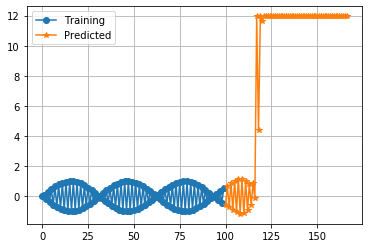

In [20]:
R3 = Op_Init_Net(10000,x_w,20,y)
R3.train(x_w,y,1000)
y_pred = Predict(R3,50,xt,True)